# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools
#testing module
from utils.testing_tools import create_test, dump_test_case, load_test_cases

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    lay1 = separable_conv2d_batchnorm(input_layer, filters, strides)
    output_layer = conv2d_batchnorm(lay1, filters, kernel_size=1, strides=1)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenated_layers = layers.concatenate([upsampled_layer, large_ip_layer])
    # TODO Add some number of separable convolution layers
    lay1 = separable_conv2d_batchnorm(concatenated_layers, filters, strides=1)
    output_layer = separable_conv2d_batchnorm(lay1, filters, strides=1)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
   
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encod1 = encoder_block(inputs, 32, 2)
    encod2 = encoder_block(encod1, 64, 2)
    encod3 = encoder_block(encod2, 128, 2)
    encod4 = encoder_block(encod3, 256, 2)
    encod5 = encoder_block(encod4, 512, 2)
        
    input_shape = inputs.get_shape().as_list()
    
    print('input layer size',input_shape)
    print('encod1 layer size',encod1.get_shape().as_list())
    print('encod2 layer size',encod2.get_shape().as_list())
    print('encod3 layer size',encod3.get_shape().as_list())
    print('encod4 layer size',encod4.get_shape().as_list())
    print('encod5 layer size',encod5.get_shape().as_list())
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_layer = conv2d_batchnorm(encod5, 512, kernel_size=1, strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decod1 = decoder_block(conv_layer, encod4, 512)
    decod2 = decoder_block(decod1, encod3, 256)
    decod3 = decoder_block(decod2, encod2, 128)
    decod4 = decoder_block(decod3, encod1, 64)
    decod5 = decoder_block(decod4, inputs, 32)


    print('conv_layer layer size',conv_layer.get_shape().as_list())
    print('decoder1  layer size',decod1.get_shape().as_list())
    print('decoder2  layer size',decod2.get_shape().as_list())
    print('decoder3  layer size',decod3.get_shape().as_list())
    print('decoder4  layer size',decod4.get_shape().as_list())
    output_shape = decod5.get_shape().as_list()
    print('decoder5  layer size',output_shape)
    
    assert (input_shape[1:2] == output_shape[1:2]), "Input/Output shapes are not the shame %r !=  %r" % (input_shape,output_shape)
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(decod5)

def fcn_model2(inputs, num_classes):
   
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encod1 = encoder_block(inputs, 2, 2)
    input_shape = inputs.get_shape().as_list()
    conv_layer = conv2d_batchnorm(encod1, 2, kernel_size=1, strides=1)
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decod1 = decoder_block(conv_layer, inputs, 2)
    
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(decod1)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)
print('output layer size',output_layer.get_shape().as_list())

input layer size [None, 160, 160, 3]
encod1 layer size [None, 80, 80, 32]
encod2 layer size [None, 40, 40, 64]
encod3 layer size [None, 20, 20, 128]
encod4 layer size [None, 10, 10, 256]
encod5 layer size [None, 5, 5, 512]
conv_layer layer size [None, 5, 5, 512]
decoder1  layer size [None, 10, 10, 512]
decoder2  layer size [None, 20, 20, 256]
decoder3  layer size [None, 40, 40, 128]
decoder4  layer size [None, 80, 80, 64]
decoder5  layer size [None, 160, 160, 32]
output layer size [None, 160, 160, 3]


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [14]:
#NEED TO LOAD TESTING TOOLS

#stract stats from the training folder 
n_valid_images = len(glob.glob(os.path.join('..', 'data', 'validation','images','*')))
n_train_images = len(glob.glob(os.path.join('..', 'data', 'train','images','*')))

#define Hyperparameters to load
encoder_type= 'DFCN'
learning_rate = 0.0001
batch_size = 50
num_epochs = 20
steps_per_epoch = int(n_train_images/num_epochs)
validation_steps = int(n_valid_images/num_epochs)
steps_per_epoch = 1
validation_steps = 1
workers = 2


test = create_test(encoder_type,learning_rate,batch_size,num_epochs,steps_per_epoch,validation_steps,workers)

tests_cases = dump_test_case(test,'DFCN_tests.p')
#Create a pickle file and load models in it
for it in tests_cases:
    print(it)
    

this settings are already loaded
{'encoder_type': 'DFCN', 'name': 'DFCN_lr001_bs50_ne20_se1_vs1_wr2', 'batch_size': 50, 'learning_rate': 0.001, 'workers': 2, 'validation_steps': 1, 'steps_per_epoch': 1, 'num_epochs': 20}
{'encoder_type': 'DFCN', 'name': 'DFCN_lr0001_bs50_ne20_se1_vs1_wr2', 'learning_rate': 0.0001, 'workers': 2, 'validation_steps': 1, 'batch_size': 50, 'steps_per_epoch': 1, 'num_epochs': 20}
{'encoder_type': 'DFCN', 'name': 'DFCN_lr001_bs50_ne20_se206_vs59_wr2', 'batch_size': 50, 'learning_rate': 0.001, 'workers': 2, 'validation_steps': 59, 'steps_per_epoch': 206, 'num_epochs': 20}


In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def train_model(test, inputs, output_layer):
    #load variables for the test
    learning_rate = test['learning_rate']
    batch_size = test['batch_size']
    steps_per_epoch = test['steps_per_epoch']
    num_epochs = test['num_epochs']
    validation_steps = test['validation_steps']
    workers = test['workers']
    
    # Define the Keras model and compile it for training
    model = models.Model(inputs=inputs, outputs=output_layer)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

    # Data iterators for loading the training and validation data
    train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                   data_folder=os.path.join('..', 'data', 'train'),
                                                   image_shape=image_shape,
                                                   shift_aug=True)

    val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                 data_folder=os.path.join('..', 'data', 'validation'),
                                                 image_shape=image_shape)

    logger_cb = plotting_tools.LoggerPlotter()
    callbacks = [logger_cb]

    model.fit_generator(train_iter,
                        steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                        epochs = num_epochs, # the number of epochs to train for,
                        validation_data = val_iter, # validation iterator
                        validation_steps = validation_steps, # the number of batches to validate on
                        callbacks=callbacks,
                        workers = workers)
    return model

DFCN_lr001_bs50_ne20_se1_vs1_wr2
Epoch 1/20


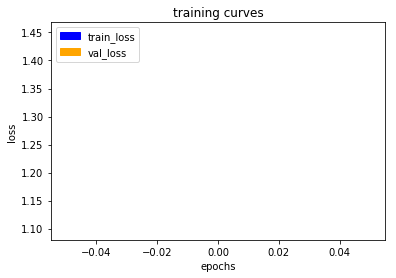

1/1 [==============================] - 13s - loss: 1.4504 - val_loss: 1.0977
Epoch 2/20


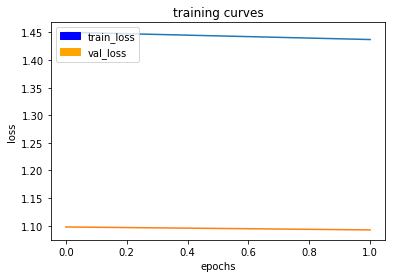

1/1 [==============================] - 10s - loss: 1.4372 - val_loss: 1.0923
Epoch 3/20


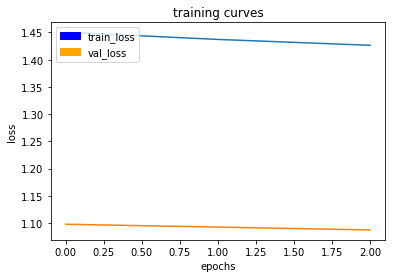

1/1 [==============================] - 7s - loss: 1.4264 - val_loss: 1.0872
Epoch 4/20


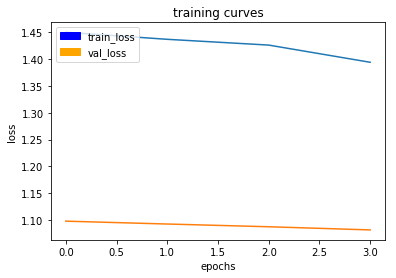

1/1 [==============================] - 8s - loss: 1.3943 - val_loss: 1.0813
Epoch 5/20


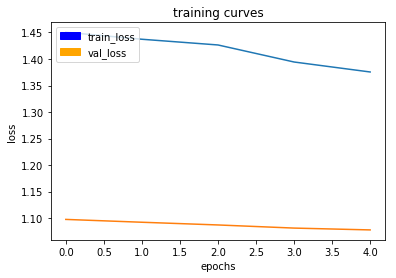

1/1 [==============================] - 7s - loss: 1.3755 - val_loss: 1.0779
Epoch 6/20


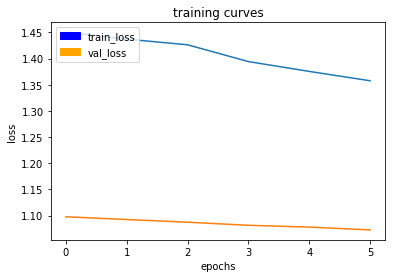

1/1 [==============================] - 7s - loss: 1.3577 - val_loss: 1.0725
Epoch 7/20


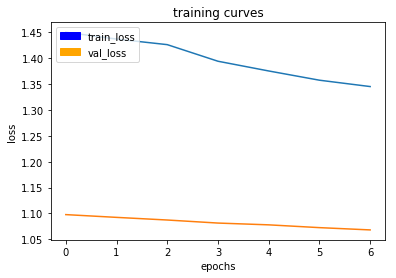

1/1 [==============================] - 7s - loss: 1.3454 - val_loss: 1.0681
Epoch 8/20


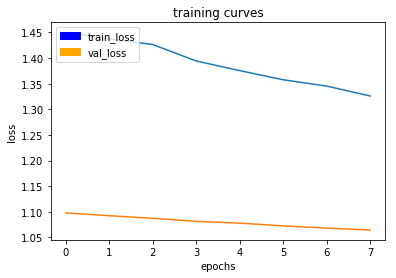

1/1 [==============================] - 7s - loss: 1.3259 - val_loss: 1.0646
Epoch 9/20


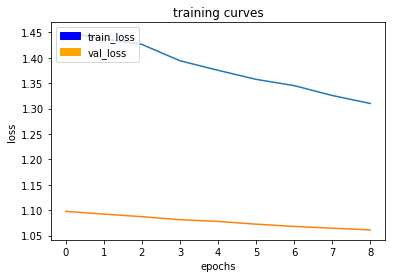

1/1 [==============================] - 6s - loss: 1.3102 - val_loss: 1.0612
Epoch 10/20


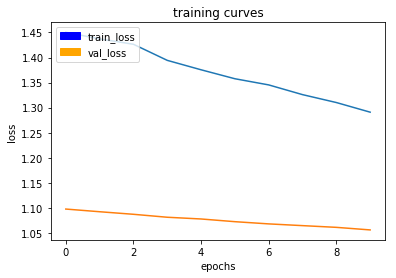

1/1 [==============================] - 7s - loss: 1.2910 - val_loss: 1.0560
Epoch 11/20


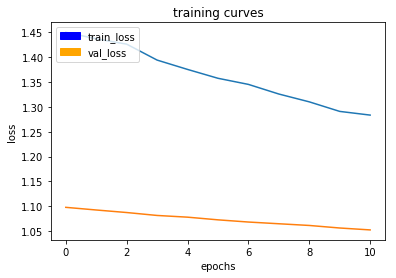

1/1 [==============================] - 6s - loss: 1.2835 - val_loss: 1.0522
Epoch 12/20


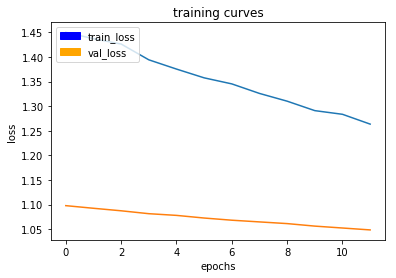

1/1 [==============================] - 7s - loss: 1.2635 - val_loss: 1.0483
Epoch 13/20


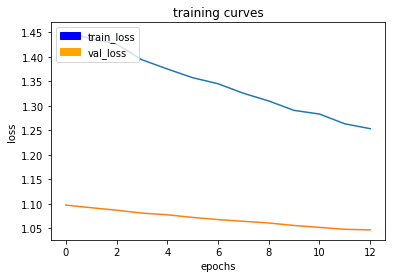

1/1 [==============================] - 6s - loss: 1.2536 - val_loss: 1.0470
Epoch 14/20


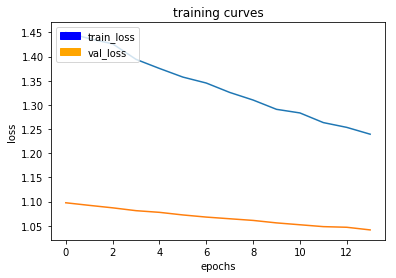

1/1 [==============================] - 8s - loss: 1.2395 - val_loss: 1.0415
Epoch 15/20


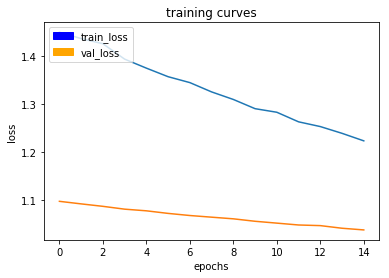

1/1 [==============================] - 6s - loss: 1.2238 - val_loss: 1.0380
Epoch 16/20


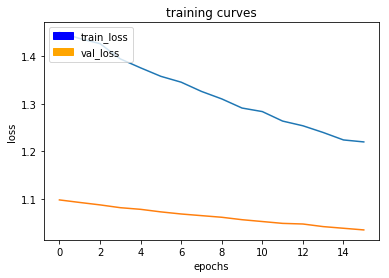

1/1 [==============================] - 6s - loss: 1.2197 - val_loss: 1.0345
Epoch 17/20


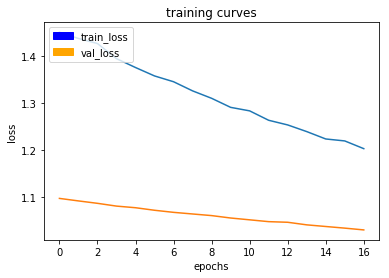

1/1 [==============================] - 6s - loss: 1.2033 - val_loss: 1.0308
Epoch 18/20


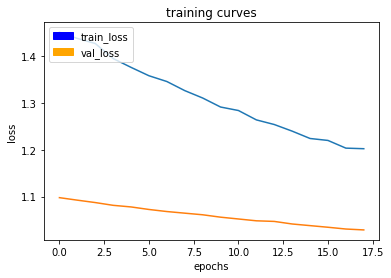

1/1 [==============================] - 7s - loss: 1.2020 - val_loss: 1.0289
Epoch 19/20


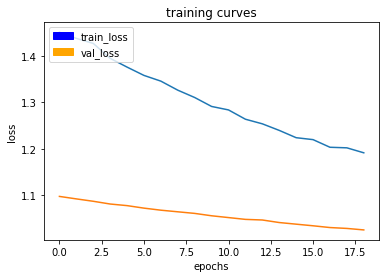

1/1 [==============================] - 6s - loss: 1.1914 - val_loss: 1.0257
Epoch 20/20


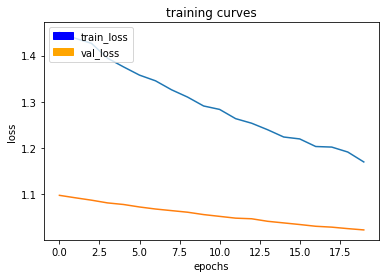

1/1 [==============================] - 7s - loss: 1.1699 - val_loss: 1.0229
DFCN_lr0001_bs50_ne20_se1_vs1_wr2
Epoch 1/20


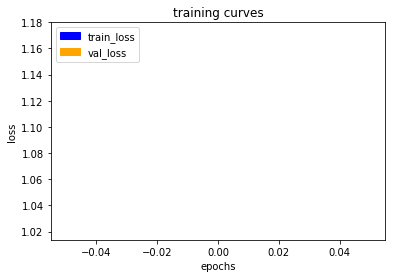

1/1 [==============================] - 13s - loss: 1.1723 - val_loss: 1.0212
Epoch 2/20


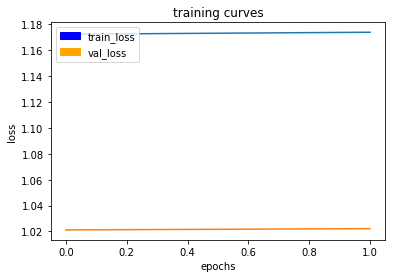

1/1 [==============================] - 6s - loss: 1.1738 - val_loss: 1.0222
Epoch 3/20


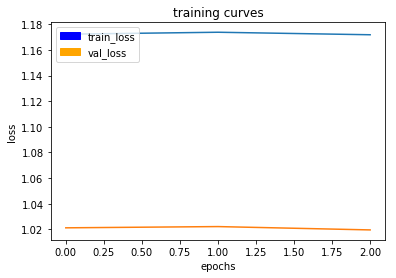

1/1 [==============================] - 7s - loss: 1.1719 - val_loss: 1.0196
Epoch 4/20


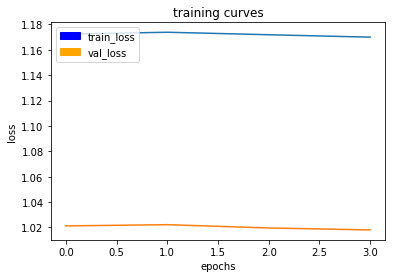

1/1 [==============================] - 6s - loss: 1.1700 - val_loss: 1.0181
Epoch 5/20


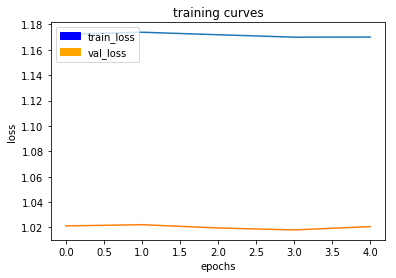

1/1 [==============================] - 6s - loss: 1.1700 - val_loss: 1.0207
Epoch 6/20


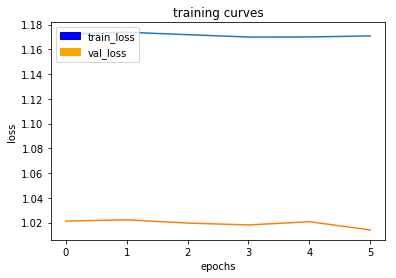

1/1 [==============================] - 5s - loss: 1.1709 - val_loss: 1.0140
Epoch 7/20


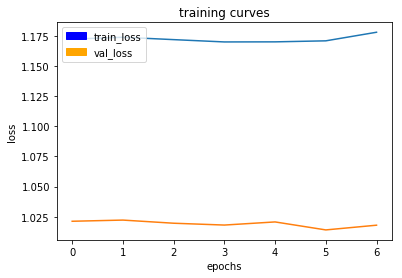

1/1 [==============================] - 7s - loss: 1.1780 - val_loss: 1.0179
Epoch 8/20


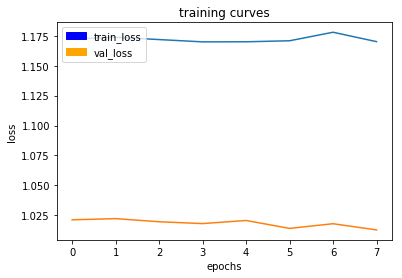

1/1 [==============================] - 6s - loss: 1.1702 - val_loss: 1.0128
Epoch 9/20


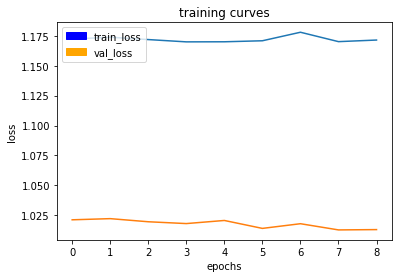

1/1 [==============================] - 6s - loss: 1.1715 - val_loss: 1.0130
Epoch 10/20


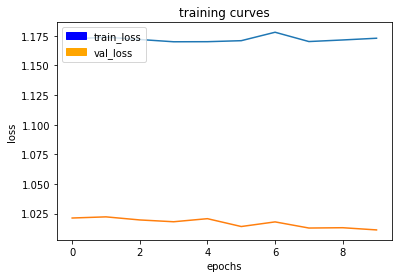

1/1 [==============================] - 6s - loss: 1.1729 - val_loss: 1.0112
Epoch 11/20


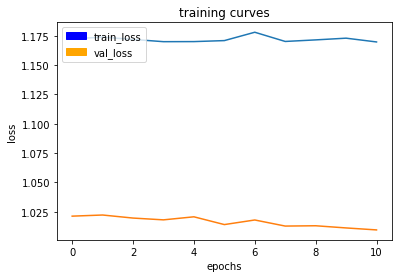

1/1 [==============================] - 7s - loss: 1.1697 - val_loss: 1.0095
Epoch 12/20


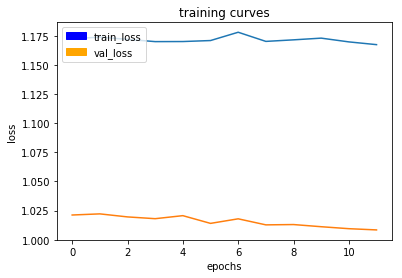

1/1 [==============================] - 4300s - loss: 1.1674 - val_loss: 1.0084
Epoch 13/20


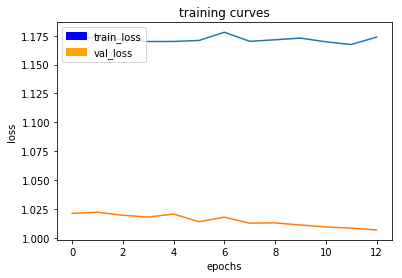

1/1 [==============================] - 10s - loss: 1.1738 - val_loss: 1.0069
Epoch 14/20


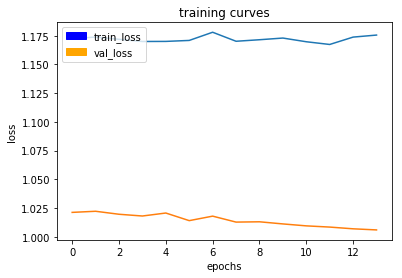

1/1 [==============================] - 8s - loss: 1.1755 - val_loss: 1.0060
Epoch 15/20


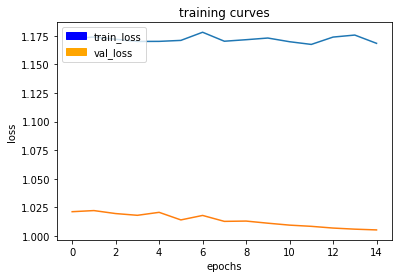

1/1 [==============================] - 9s - loss: 1.1683 - val_loss: 1.0053
Epoch 16/20


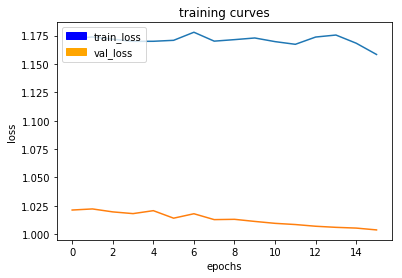

1/1 [==============================] - 8s - loss: 1.1584 - val_loss: 1.0037
Epoch 17/20


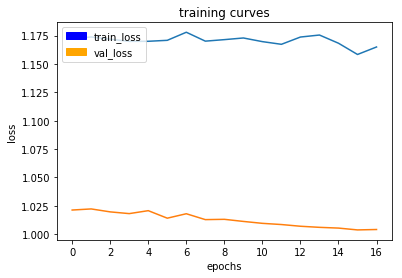

1/1 [==============================] - 7s - loss: 1.1650 - val_loss: 1.0040
Epoch 18/20


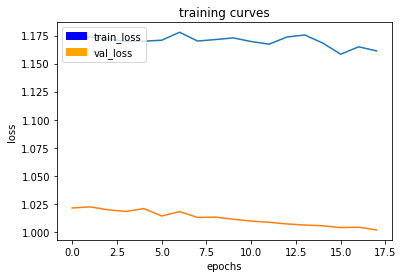

1/1 [==============================] - 6s - loss: 1.1614 - val_loss: 1.0016
Epoch 19/20


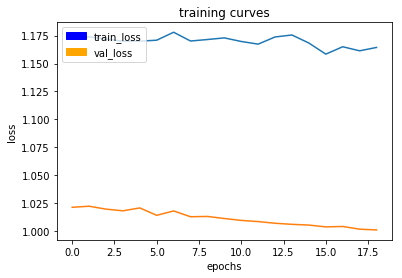

1/1 [==============================] - 7s - loss: 1.1644 - val_loss: 1.0010
Epoch 20/20


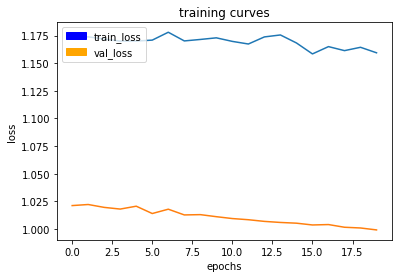

1/1 [==============================] - 6s - loss: 1.1594 - val_loss: 0.9992


In [13]:
# Save your trained model weights
import time
import pickle
#loop over all the test cases defined and save the training time
training_times = []
for test in tests_cases:
    print(test['name'])
    test_training_time = {}
    test_training_time['name'] = test['name']
    #start the clock
    test_training_time['start'] = time.time()
    #train the model
    
    model = train_model(test, inputs, output_layer)
    #stop the clock
    test_training_time['finish'] = time.time()
    #append to dict
    training_times.append(test_training_time)
    #save the weights of the model for evaluation
    weight_file_name = test['name']
    model_tools.save_network(model, weight_file_name)
    
    
#save the times
with open('train_time.p', 'wb+') as file:
    pickle.dump(training_times, file)

In [14]:
for it in training_times:
    print(it['name'], it['finish'] - it['start'])

DFCN_lr001_bs50_ne1_se1_vs1_wr2 16.128817558288574
DFCN_lr0001_bs50_ne1_se1_vs1_wr2 12.1294424533844


## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [41]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights_1'
model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [42]:
run_num = 'run_model_weights_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

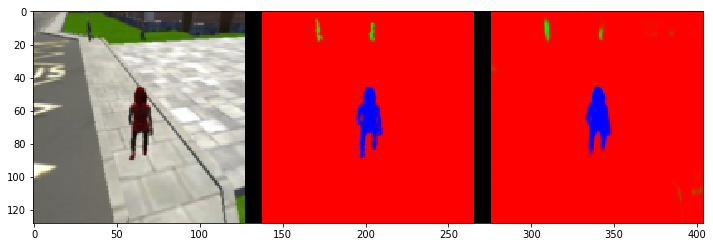

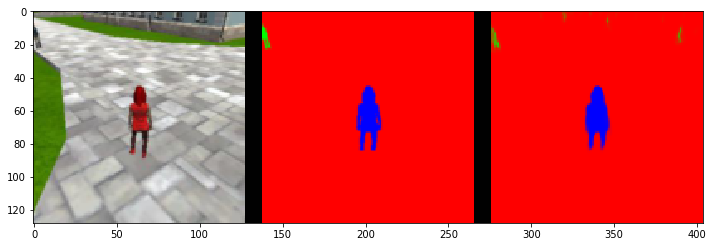

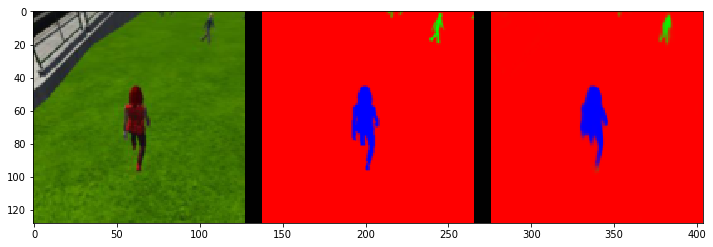

In [43]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

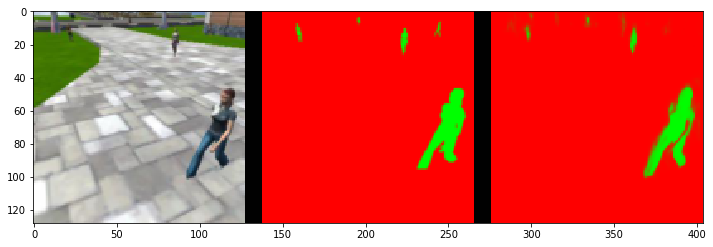

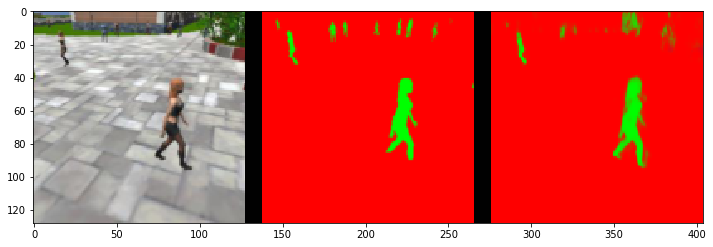

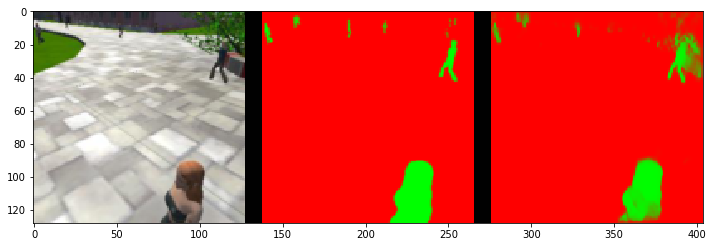

In [44]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

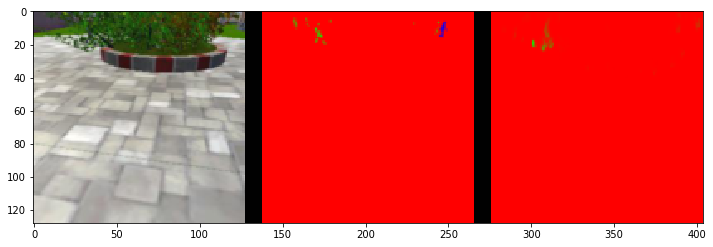

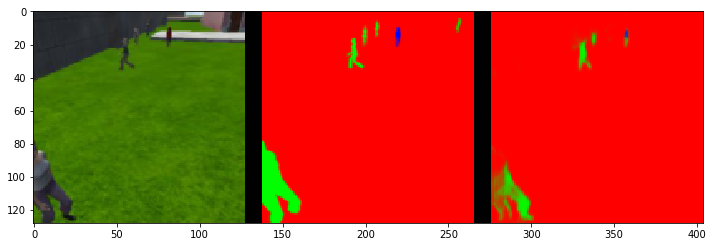

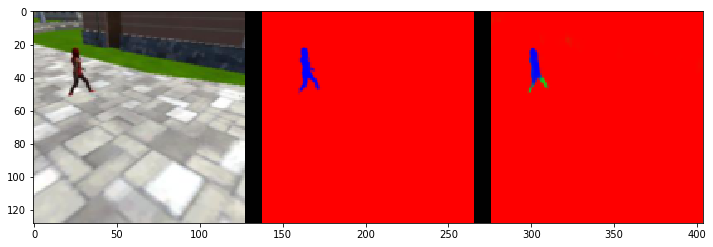

In [45]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [46]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9937952004753994
average intersection over union for other people is 0.25865072467297645
average intersection over union for the hero is 0.865191743138584
number true positives: 539, number false positives: 0, number false negatives: 0


In [47]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9845301436098615
average intersection over union for other people is 0.6744962012034031
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 14, number false negatives: 0


In [48]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9959899343893417
average intersection over union for other people is 0.3412938423206592
average intersection over union for the hero is 0.11590650800115967
number true positives: 84, number false positives: 1, number false negatives: 206


In [49]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7381516587677726


In [50]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.49054912557


In [51]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.362099650746
